# Plot Multiple Timepoints

This script creates plots that summarize the evolution of the density in differt ROIs across differt timepoints. The Region of Injection is keept constant.

## Packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Mandatory Input

In [2]:
# Dir of the project (if script is run on batch mode, i.e. for all brains of the project)
dir_project = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset"

# Csv file with all the brains data
csv_file = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/Results/all_brains.csv"

# number of the ROI to display in a plot
n_roi_displayed = 10 

# List of region to injection to invesigate (one for each folder in the porject)
region_injections = ["DR", "STN", "PARN", "IF", "GPi", "GPe", "CU", "BST"]
# List of Timepoints to investigate
timepoints = ["Uninjured", "1 weeks", "8 weeks"]


## Useful Functions

In [3]:
def data_summary(data, varname, groupnames):
    """
    Function to calculate the mean and standard error for each group, preserving the original order.

    Parameters:
    - data: A pandas DataFrame containing the data.
    - varname: The name of the column containing the variable to be summarized (string).
    - groupnames: A list of column names to be used as grouping variables (list of strings).

    Returns:
    - data_sum: A pandas DataFrame with mean and standard error for each group, preserving the original order.
    """
    
    # Add an index column to preserve the original order
    data['_order'] = range(len(data))
    
    # Group the data by the specified group names
    grouped = data.groupby(groupnames)
    
    # Calculate the mean and standard error for the specified variable
    data_sum = grouped[varname].agg(
        mean='mean', 
        std='std', 
        count='count'
    ).reset_index()
    
    # Calculate standard error
    data_sum['sem'] = data_sum['std'] / np.sqrt(data_sum['count'])
    
    # Merge the summary with the original data to preserve the order
    data_sum = pd.merge(data[groupnames + ['_order']], data_sum, on=groupnames).sort_values('_order')

    # Check for duplicates in the summary DataFrame
    if data_sum.duplicated(subset=groupnames).any():
        print("Warning: Duplicates found in the summarized data!")
        # Drop duplicates, keeping the first occurrence
        data_sum = data_sum.drop_duplicates(subset=groupnames)
    
    # Sort the summary DataFrame based on the preserved order from the original data
    data_sum['_order'] = data.groupby(groupnames)['_order'].first().values
    data_sum = data_sum.sort_values('_order')
    
    # Drop the temporary _order column
    data_sum = data_sum.drop(columns=['_order'])
    
    # Rename the mean and sem columns
    data_sum = data_sum.rename(columns={'mean': varname + '_mean', 'sem': varname + '_sem', 'std': varname + '_std'})
    
    # Drop the 'std' and 'count' columns, as they are not needed
    #data_sum = data_sum.drop(columns=['std', 'count'])
    
    return data_sum

def search_injection_folder(base_dir, name_dir_to_search):
    """
    Searches for a subfolder with a specific name within the given base directory.

    Parameters:
    - base_dir: The path of the base directory to search within (string).
    - name_dir_to_search: The name of the subfolder to search for (string).

    Returns:
    - The full path of the subfolder if found, or None if not found.
    """
    # Ensure the base directory exists
    if not os.path.isdir(base_dir):
        raise ValueError(f"The base directory '{base_dir}' does not exist or is not a directory.")
    
    # Walk through the directory tree
    for root, dirs, files in os.walk(base_dir):
        if name_dir_to_search in dirs:
            # Return the full path to the subfolder
            return os.path.join(root, name_dir_to_search)
    
    # Return None if the subfolder was not found
    return None


## Read csv all Brains

In [4]:
df_all = pd.read_csv(csv_file)

## 3 Timepoints Barplot most dense, different x-axis

In [16]:
# Summarize data
df_summary = data_summary(df_all, varname="Cell Density", groupnames=["TimePoint", "Region Injection", "ROI"])
    # in this way I take the mean of:
        # the same ROI, coming from mice of the same timepoint and same Region Injection

# Loop over each region
for region in region_injections:

    print(f"Analyzing data for Region Injection: {region}")
    
    # Set up the plot grid
    n_plots = len(timepoints)
    fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(5 * n_plots, 6), sharey=True)
    
    if n_plots == 1:
        axes = [axes]  # Ensure axes is a list even for a single plot
    
    # Plot for each time point
    for i, timepoint in enumerate(timepoints):
        
        # Filter data for the current time point
        t = df_summary[(df_summary["TimePoint"] == timepoint) & (df_summary["Region Injection"] == region)]
        
        # Sort by mean density and select top ROIs
        t_sorted = t.sort_values(by="Cell Density_mean", ascending=False).head(n_roi_displayed)
        
        # Create the bar plot on the corresponding subplot
        axes[i].bar(t_sorted["ROI"], t_sorted["Cell Density_mean"], yerr=t_sorted["Cell Density_sem"], color="lightblue", capsize=5)
        axes[i].set_title(f"{timepoint}")
        axes[i].set_xticks(range(len(t_sorted["ROI"])))  # Set the positions of the ticks
        axes[i].set_xticklabels(t_sorted["ROI"], rotation=45, ha='right')  # Set the labels
        axes[i].set_ylim(0, 0.02)
    
    # Set a common y-label
    fig.text(0.04, 0.5, 'Cell Density Mean', va='center', rotation='vertical')
    
    # Adjust layout
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    
    # Save the combined plot
    injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
    result_folder = os.path.join(injection_folder, "Results") 
    os.makedirs(result_folder, exist_ok=True)
    fig.savefig(os.path.join(result_folder, f"timepoints_barplot_different_xaxis_{n_roi_displayed}.pdf"), bbox_inches="tight")

plt.close("all")


Analyzing data for Region Injection: DR
Analyzing data for Region Injection: STN
Analyzing data for Region Injection: PARN
Analyzing data for Region Injection: IF
Analyzing data for Region Injection: GPi
Analyzing data for Region Injection: GPe
Analyzing data for Region Injection: CU
Analyzing data for Region Injection: BST


## Barplot Multiple columns

In [17]:
# Summarize data
df_summary = data_summary(df_all, varname="Cell Density", groupnames=["TimePoint", "Region Injection", "ROI"])
    # in this way I take the mean of:
        # the same ROI, coming from mice of the same timepoint and same Region Injection

def multiple_bar_barplot(df_summary, baseline_timepoint = "Uninjured"):

    print(f"Analyzing baseline {baseline_timepoint}")
    # Define colors for the timepoints
    colors = plt.get_cmap('tab10').colors  # Use the 'tab10' colormap for distinct colors
    color_map = {timepoint: colors[i % len(colors)] for i, timepoint in enumerate(timepoints)}
        
    for region in region_injections:
        print(f"\tAnalyzing data for Region Injection: {region}")

        # Select only specific region of injection
        df_region = df_summary[df_summary["Region Injection"] == region]

        if df_region.shape[0] == 0:
            print(f"\t\tATTENTION --> No data for Injection Region {region}")
            continue

        # Filter data for the baseline case
        baseline_data = df_region[df_region["TimePoint"] == baseline_timepoint]

        # Find the most dense region for the "Uninjured" case
        most_dense_regions = baseline_data.sort_values(by="Cell Density_mean", ascending=False).head(n_roi_displayed)
        most_dense_region_list = most_dense_regions["ROI"].tolist()
        
        # Filter data for the specific regions and timepoints
        filtered_data = df_region[df_region["ROI"].isin(most_dense_region_list)]

        if filtered_data.shape[0] == 0:
            print(f"\t\tATTENTION --> No data for baseline {baseline_timepoint} in Injection Region {region}")
            continue

        # Pivot data for plotting
        pivot_data = filtered_data.pivot_table(index="ROI", columns="TimePoint", values="Cell Density_mean", aggfunc='mean')
        pivot_errors = filtered_data.pivot_table(index="ROI", columns="TimePoint", values="Cell Density_sem", aggfunc='mean')

        # Ensure columns are ordered by the given timepoints list and include only available timepoints
        available_timepoints = [tp for tp in timepoints if tp in pivot_data.columns]
        pivot_data = pivot_data[available_timepoints]
        pivot_errors = pivot_errors[available_timepoints]

        # Ensure order is decreseing based oin baseline timepoint
        pivot_data = pivot_data.sort_values(by=baseline_timepoint, ascending=False)
        pivot_errors = pivot_errors.sort_values(by=baseline_timepoint, ascending=False)

        # Create a single bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot_data.plot(kind='bar', yerr=pivot_errors, ax=ax, capsize=5, color=[color_map[timepoint] for timepoint in timepoints])

        # Format the plot
        ax.set_title(f"Cell Density for Region Injection: {region} (Top Dense Regions)")
        ax.set_xlabel("ROI")
        ax.set_ylabel("Cell Density Mean")
        ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
        ax.set_ylim(0, 0.02)

        # Adjust layout
        plt.tight_layout()
        
        # Save the combined plot
        injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
        result_folder = os.path.join(injection_folder, "Results") 
        os.makedirs(result_folder, exist_ok=True)
        fig.savefig(os.path.join(result_folder, f"timepoints_barplot_muultiple_bars_baseline_{baseline_timepoint}_{n_roi_displayed}.pdf"), bbox_inches="tight")

        print(f"\t\tSuccess!")

    plt.close("all")
    print("\n")


for t in timepoints:
    multiple_bar_barplot(df_summary, baseline_timepoint=t)




Analyzing baseline Uninjured
	Analyzing data for Region Injection: DR
		Success!
	Analyzing data for Region Injection: STN
		ATTENTION --> No data for Injection Region STN
	Analyzing data for Region Injection: PARN
		ATTENTION --> No data for Injection Region PARN
	Analyzing data for Region Injection: IF
		ATTENTION --> No data for Injection Region IF
	Analyzing data for Region Injection: GPi
		Success!
	Analyzing data for Region Injection: GPe
		Success!
	Analyzing data for Region Injection: CU
		ATTENTION --> No data for Injection Region CU
	Analyzing data for Region Injection: BST
		ATTENTION --> No data for Injection Region BST


Analyzing baseline 1 weeks
	Analyzing data for Region Injection: DR
		Success!
	Analyzing data for Region Injection: STN
		ATTENTION --> No data for Injection Region STN
	Analyzing data for Region Injection: PARN
		ATTENTION --> No data for Injection Region PARN
	Analyzing data for Region Injection: IF
		ATTENTION --> No data for Injection Region IF
	Analy

## Barplot LogFC

#### Function to plot logFC

In [8]:
def plot_logFC(region, df_region, test_name, save_path, logFC_bound=1000):
    
    # Sort values
    df_region = df_region.sort_values(by=test_name, ascending=False)

    # Take the biggest and smallest in absolute values ROI with logFC
    # Also take the ones that have been bounded
    df_temp = df_region.copy()

    # Filter for extreme ROIs based on the logFC bound
    extreme_rois = df_temp[~((df_temp[test_name] < logFC_bound) & (df_temp[test_name] > -logFC_bound))].index.to_list()
        # NB .index is the names of the ROI column

    # Take only normal ROIs (within the bounds)
    df_temp = df_temp[(df_temp[test_name] < logFC_bound) & (df_temp[test_name] > -logFC_bound)]

    # Get top and bottom ROIs
    top_rois = df_temp.head(n_roi_displayed).index.to_list() # Take the biggest
    bottom_rois = df_temp.tail(n_roi_displayed).index.to_list() # Take the smallest

    # Filter the original DataFrame to include top, bottom, and extreme ROIs
    df_temp = df_region[
        df_region.index.isin(top_rois) | 
        df_region.index.isin(bottom_rois) | 
        df_region.index.isin(extreme_rois)
    ]

    df_temp = df_temp[[test_name]]

    #print(df_temp.to_string())

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(20, 10 ))
    bars = plt.bar(df_temp.index, df_temp[test_name])

    ax.set_xlabel('ROI')
    ax.set_ylabel(test_name)
    ax.set_title('Most extreme changed in LogFC')
    ax.set_xticks(range(len(df_temp.index)))  # Set the positions of the ticks
    ax.set_xticklabels(df_temp.index, rotation=45, ha='right')  # Set the labels at those positions
    ax.set_ylim(bottom = -10, top = 10)
    #plt.show()

    fig.savefig(save_path)

    print(f"Saved {test_name} for region {region}")

#### Calculate LogFC

In [9]:
df_all_pivot = df_all.pivot(index="ROI", columns=["Brain ID", "Region Injection", "TimePoint"], values="Cell Density")
    #Attnetion: now the name of a col is a list
print(df_all_pivot)
#print(df_all_pivot.columns)

Brain ID               100       101       602       601       200       201  \
Region Injection        DR        DR        DR        DR        DR        DR   
TimePoint          8 weeks   8 weeks Uninjured Uninjured   1 weeks   1 weeks   
ROI                                                                            
Left: AAA         0.000236  0.000184  0.000236  0.001032  0.000184  0.000158   
Left: ACA         0.000285  0.000262  0.000285  0.000214  0.000262  0.000292   
Left: ACAd        0.000316  0.000263  0.000316  0.000227  0.000263  0.000283   
Left: ACAd1       0.000121  0.000071  0.000121  0.000035  0.000071  0.000142   
Left: ACAd2/3     0.000243  0.000202  0.000243  0.000183  0.000202  0.000230   
...                    ...       ...       ...       ...       ...       ...   
Right: vhc        0.000030  0.000000  0.000030  0.000013  0.000000  0.000063   
Right: von        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Right: vtd        0.002945  0.000000  0.

Saved logFC_1weeks_uninjured for region DR
Saved logFC_8weeks_1week for region DR
Saved logFC_8weeks_uninjured for region DR


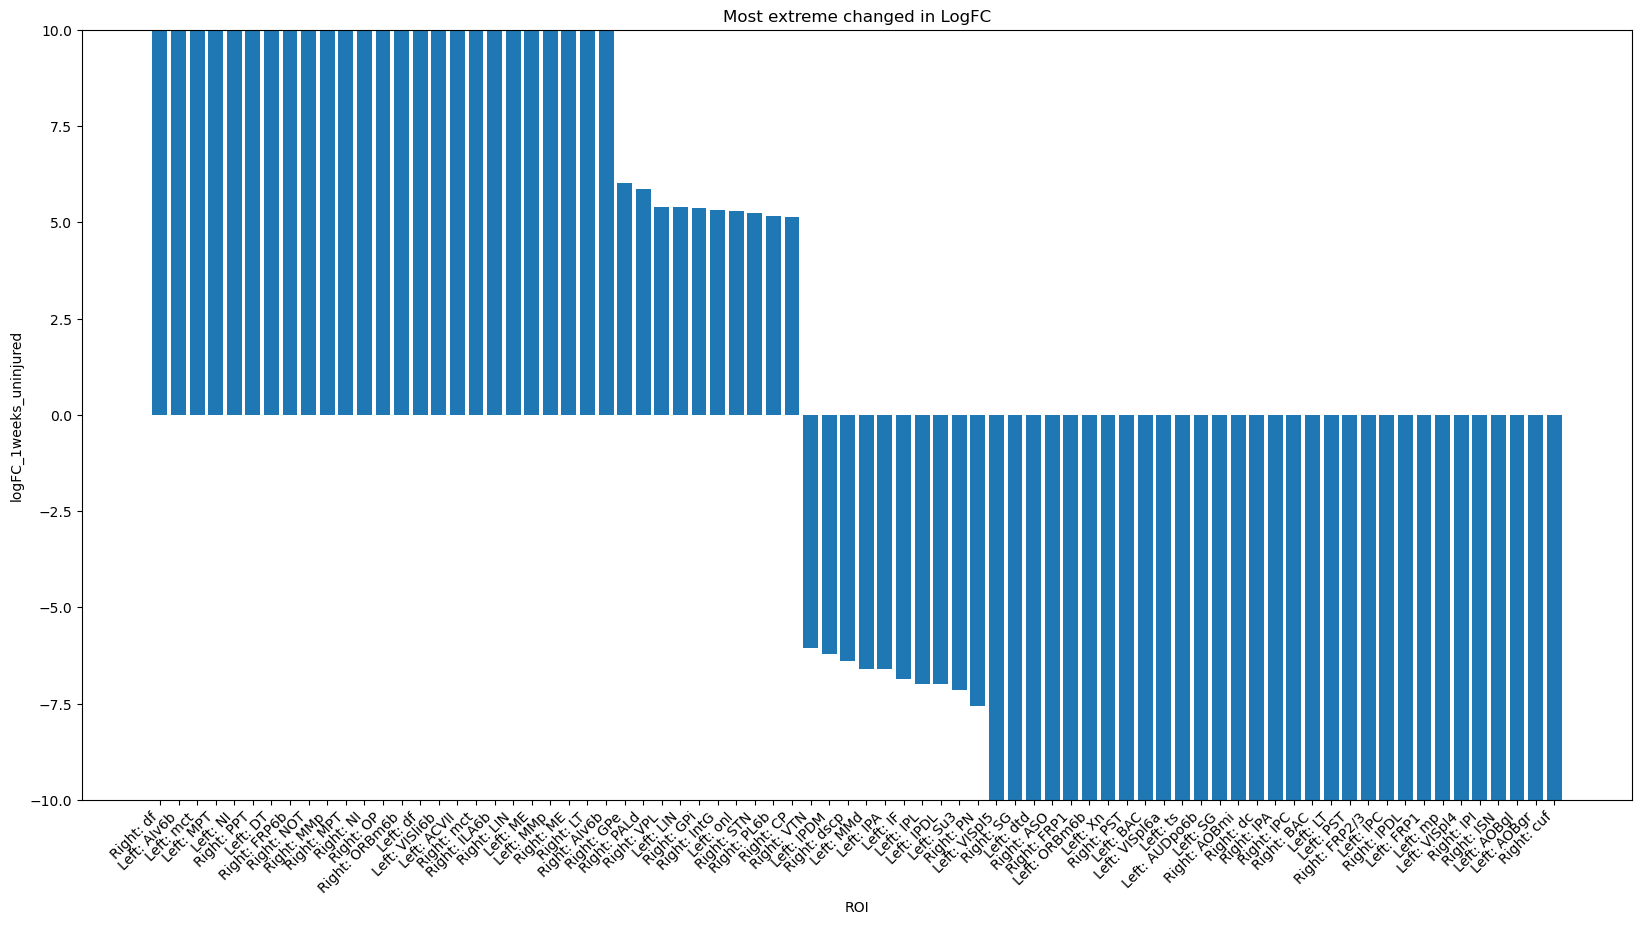

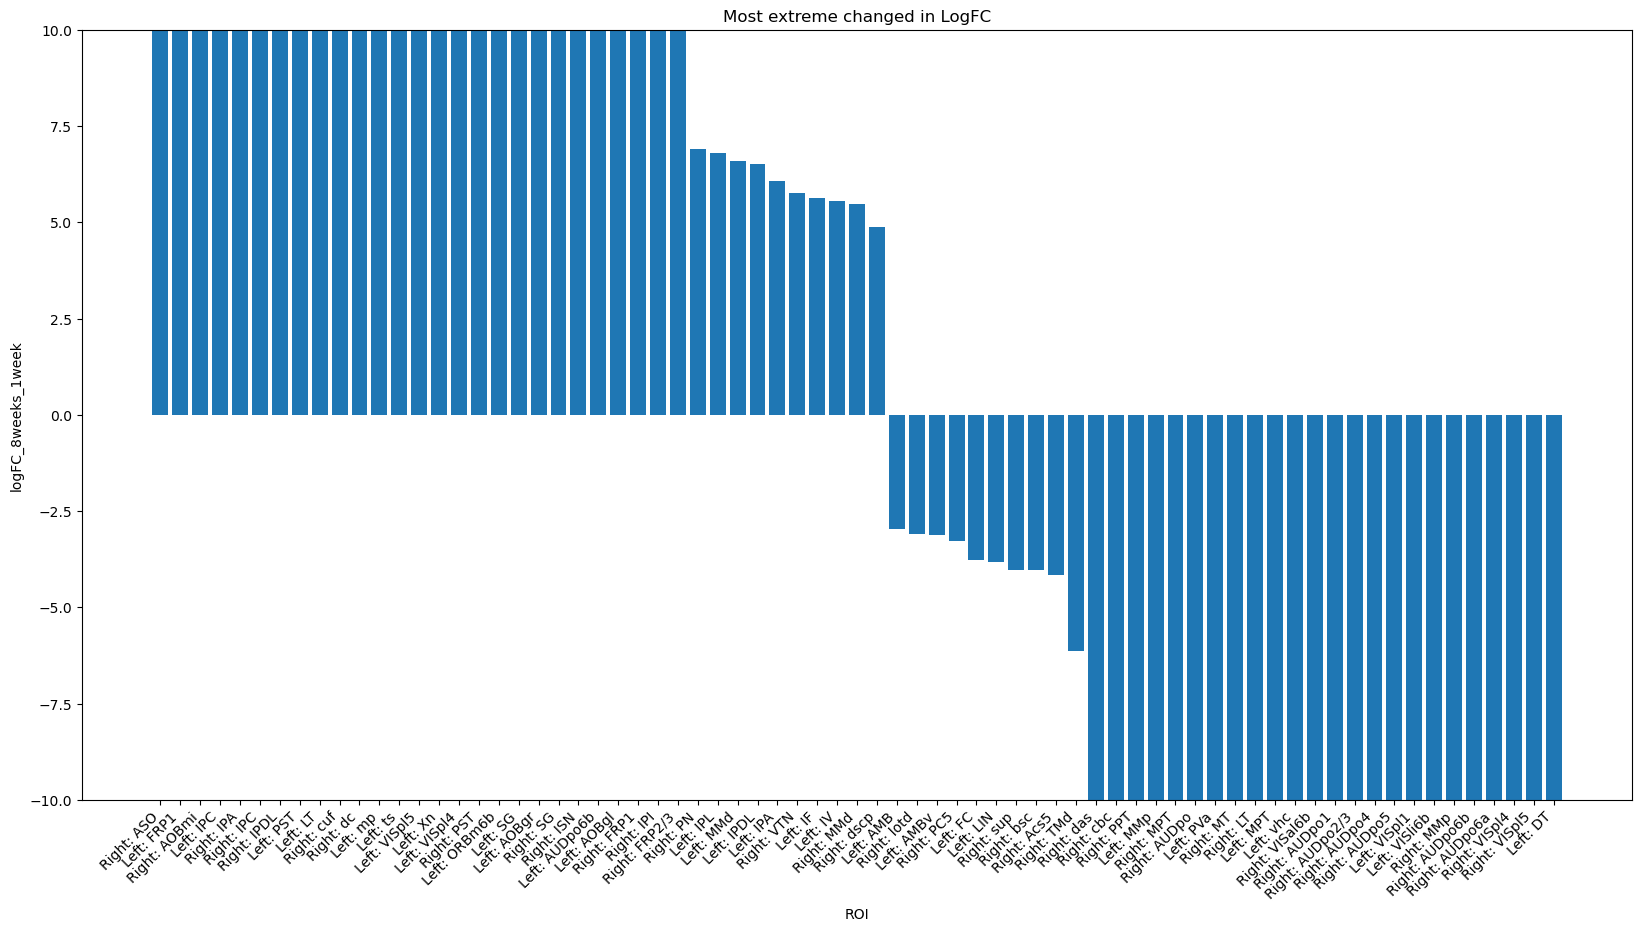

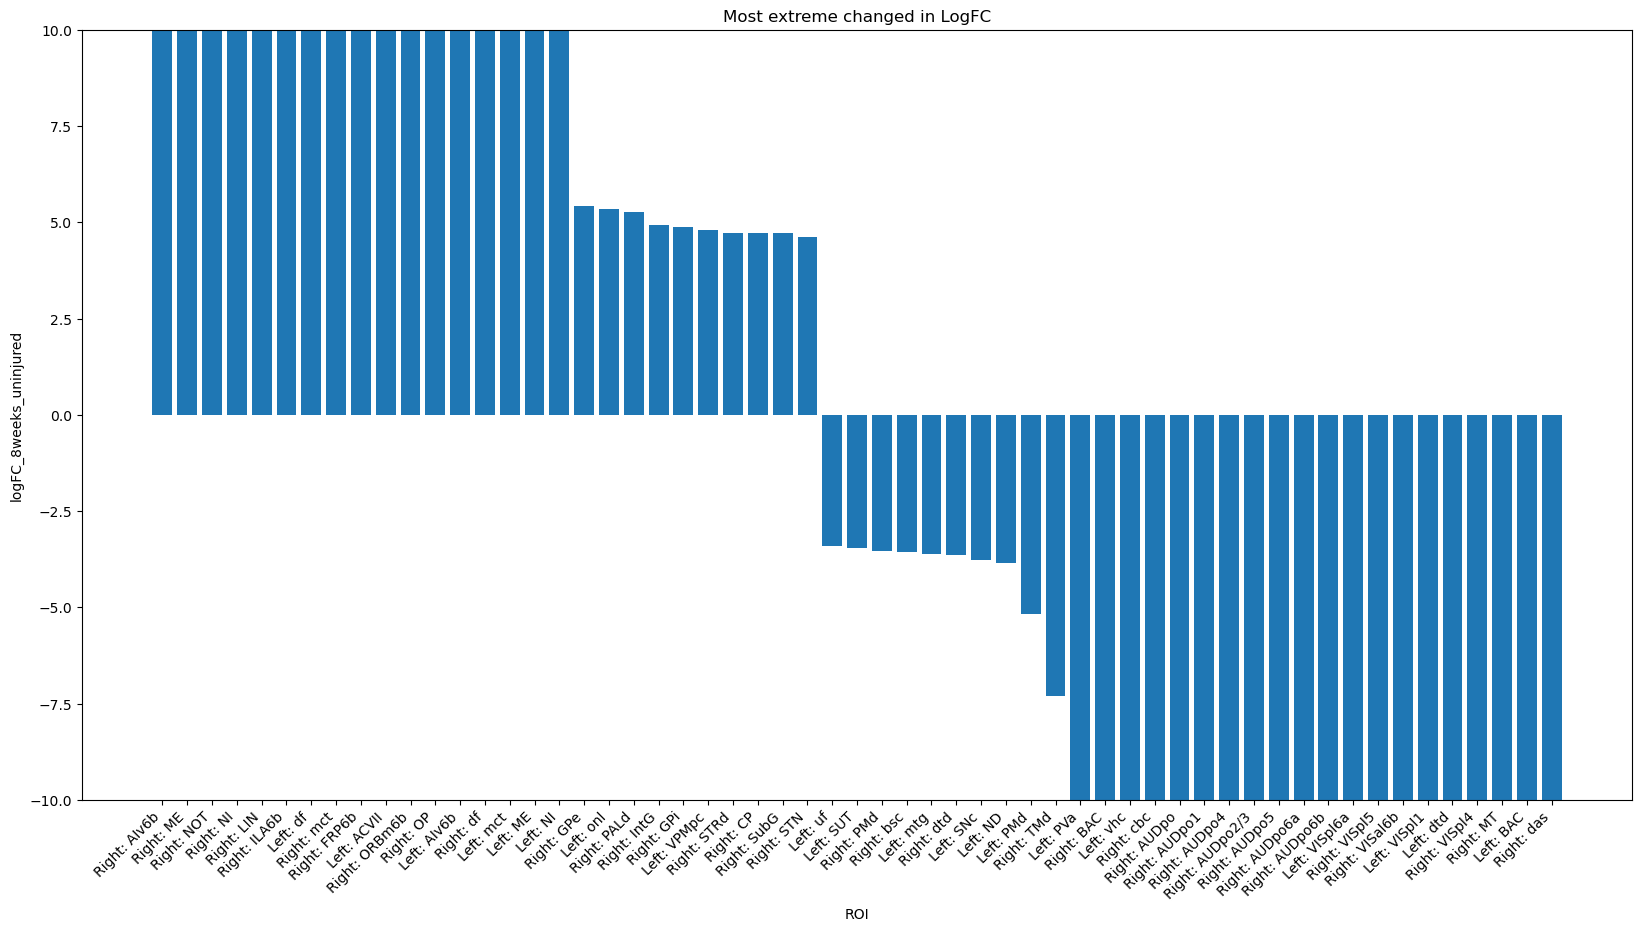

In [14]:

for i, region in enumerate(region_injections):

    # Select only mice of specific region (i,e spefifcols of df)
    ok_cols = [col for col in df_all_pivot.columns if region in col[1]] #now the names of the col is a list!!!!
    df_region = df_all_pivot[ok_cols]
    #print(df_region)

    if df_region.shape[0] == 0:
        print(f"No Samples for region {region}")

    mean_roi_uninjured = []
    mean_roi_1weeks = []
    mean_roi_8weeks = []
    logFC_1weeks_uninjured = [] # Second one is the baseline
    logFC_8weeks_1week = []
    logFC_8weeks_uninjured = []

    # For each row, lets add some metrics: mean within timepoints, logFC
    # Iterate over each row in the DataFrame
    for index, row in df_region.iterrows():
        
        roi = row.name

        ## Calculate mean roi of each timepoint
        
        # Dynamically find columns that belong to G1 and G2
        uninjured_cols = [col for col in df_region.columns if 'Uninjured' in col[2]]
        _1weeks_cols = [col for col in df_region.columns if '1 weeks' in col[2]]
        _8weeks_cols = [col for col in df_region.columns if '8 weeks' in col[2]]
        
        # Extract the values for these columns
        uninjured_values = [row[col] for col in uninjured_cols if col in row]
        _1weeks_values = [row[col] for col in _1weeks_cols if col in row]    
        _8weeks_values = [row[col] for col in _8weeks_cols if col in row]  

        # Tag which values we have
        uninjured_present = True
        _1_weeks_present = True
        _8_weeks_present = True

        if len(uninjured_values) == 0:
            print("\tNo Samples for Uninjured.")
            uninjured_present = False
        if len(_1weeks_values) == 0:
            print("\tNo Samples for 1 Weeks.")
            _1weeks_present = False
        if len(_8weeks_values) == 0:
            print("\tNo Samples for 8 Weeks.")
            _8weeks_present = False


        # Append Means
        mean_uninjured = np.mean(uninjured_values)
        mean_1weeks = np.mean(_1weeks_values)
        mean_8weeks = np.mean(_8weeks_values)
        mean_roi_uninjured.append(mean_uninjured)
        mean_roi_1weeks.append(mean_1weeks)
        mean_roi_8weeks.append(mean_8weeks)

        # Append LogFC
        logFC_bound = 1000 # used to signal which case are stinge
            #baseline 0 treatment 0 --> not importat --> put 0
            #baseline N treatment 0 --> decresed a lot --> put -bound
            #baseline 0 treatment N --> increased a lot --> put bound
            #baseline N treatment N --> normal --> put fraztion

        logFC_1weeks_uninjured_value = 0
        mean_baseline = mean_uninjured
        mean_treatment = mean_1weeks
        if mean_baseline == 0 and mean_treatment == 0: # Not important case
            logFC_1weeks_uninjured_value = 0
        elif mean_baseline == 0 and mean_treatment != 0:
            logFC_1weeks_uninjured_value = logFC_bound
        elif mean_baseline != 0 and mean_treatment == 0:
            logFC_1weeks_uninjured_value = -logFC_bound
        elif mean_baseline != 0 and mean_treatment != 0: # Normal case
            logFC_1weeks_uninjured_value = np.log2(mean_treatment / mean_baseline)

        logFC_8weeks_1weeks_value = 0
        mean_baseline = mean_1weeks
        mean_treatment = mean_8weeks
        if mean_baseline == 0 and mean_treatment == 0: # Not important case
            logFC_8weeks_1weeks_value = 0
        elif mean_baseline == 0 and mean_treatment != 0:
            logFC_8weeks_1weeks_value = logFC_bound
        elif mean_baseline != 0 and mean_treatment == 0:
            logFC_8weeks_1weeks_value = -logFC_bound
        elif mean_baseline != 0 and mean_treatment != 0: # Normal case
            logFC_8weeks_1weeks_value = np.log2(mean_treatment / mean_baseline)

        logFC_8weeks_uninjured_value = 0
        mean_baseline = mean_uninjured
        mean_treatment = mean_8weeks
        if mean_baseline == 0 and mean_treatment == 0: # Not important case
            logFC_8weeks_uninjured_value = 0
        elif mean_baseline == 0 and mean_treatment != 0:
            logFC_8weeks_uninjured_value = logFC_bound
        elif mean_baseline != 0 and mean_treatment == 0:
            logFC_8weeks_uninjured_value = -logFC_bound
        elif mean_baseline != 0 and mean_treatment != 0: # Normal case
            logFC_8weeks_uninjured_value = np.log2(mean_treatment / mean_baseline)
        
        logFC_1weeks_uninjured.append(logFC_1weeks_uninjured_value)
        logFC_8weeks_1week.append(logFC_8weeks_1weeks_value)
        logFC_8weeks_uninjured.append(logFC_8weeks_uninjured_value)

    # Add the results to the original DataFrame
    df_region = df_region.copy()
    df_region.loc[:, 'mean_uninjured'] = mean_roi_uninjured
    df_region.loc[:, 'mean_1weeks'] = mean_roi_1weeks
    df_region.loc[:, 'mean_8weeks'] = mean_roi_8weeks
    df_region.loc[:, "logFC_1weeks_uninjured"] = logFC_1weeks_uninjured
    df_region.loc[:, "logFC_8weeks_1week"] = logFC_8weeks_1week
    df_region.loc[:, "logFC_8weeks_uninjured"] = logFC_8weeks_uninjured

    #print(df_region)

    # Create reuslt folder
    injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
    result_folder = os.path.join(injection_folder, "Results") 
    os.makedirs(result_folder, exist_ok=True)

    ###
    # PLOT 1: LogFC_1weeks_unijured
    ### 
    save_path = os.path.join(result_folder, f"logFC_1weeks_uninjured_{region}_{n_roi_displayed}.pdf")
    plot_logFC(region = region, df_region = df_region, test_name = "logFC_1weeks_uninjured", save_path=save_path)

    ###
    # PLOT 2: LogFC_8weeks_1weeks
    ### 
    save_path = os.path.join(result_folder, f"logFC_8weeks_1week_{region}_{n_roi_displayed}.pdf")
    plot_logFC(region = region, df_region = df_region, test_name = "logFC_8weeks_1week", save_path=save_path)

    ###
    # PLOT 2: LogFC_8weeks_uninjured
    ### 
    save_path = os.path.join(result_folder, f"logFC_8weeks_uninjured_{region}_{n_roi_displayed}.pdf")
    plot_logFC(region = region, df_region = df_region, test_name = "logFC_8weeks_uninjured", save_path=save_path)

    break
    print(i)
    if i>=1:
        break  


